## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

### Navegación por la presentación:
* Para ir hacia adelante: barra espaciadora
* Para retornar: shift + barra espaciadora

### Data
La data utilizada es la proporcionada por la posta en una gráfica publicada con datos hasta 18 marzo.

### Objetivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. (Pendiente)
* Corregir los cálculos del primer objetivo considerando el factor movilidad (Pendiente)

### Objetivos:
* Modelar considerando cómo el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Organizo los datos del gráfico de **La Posta** en un archivo csv

In [2]:
os.listdir()

['rise.css',
 'CoronaVirusEcu.ipynb',
 '.gitignore',
 'environment.yml',
 'coronavirusEcu.csv',
 '.ipynb_checkpoints',
 'README.md',
 'images',
 '.git',
 'coronavirusEcu_formatted.csv']

In [3]:
df = pd.read_csv('coronavirusEcu.csv')
df


,Date,Number_of_Cases
0,2020-02-28,0
1,2020-02-29,1
2,2020-03-01,6
3,2020-03-02,7
4,2020-03-04,10
5,2020-03-05,13
6,2020-03-06,14
7,2020-03-08,15
8,2020-03-10,17
9,2020-03-12,19


Se obtiene el gráfico original de los datos proveídos

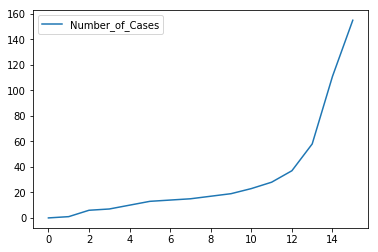

In [4]:
df.plot.line()


En forma similar a la referencia seguida en esta presentación, se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [5]:
FMT = '%Y-%m-%d'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
df

,Date,Number_of_Cases
0,58,0
1,59,1
2,60,6
3,61,7
4,63,10
5,64,13
6,65,14
7,67,15
8,69,17
9,71,19


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [6]:
df.to_csv('coronavirusEcu_formatted.csv')

Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [7]:
y = np.array(df['Number_of_Cases'].values.tolist())
y

array([  0,   1,   6,   7,  10,  13,  14,  15,  17,  19,  23,  28,  37,
        58, 111, 155])

In [8]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = np.array(df['Date'])
x

array([58, 59, 60, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 75, 76, 77])

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, ésta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$: número de contagiados o casos totales
* $x$: día del año para el que se tiene un valor determinado de contagiados
* $a$: velocidad de infección.
* $b$: día en el que ocurre el máximo de infecciones
* $c$: total de infectados en la población.

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [10]:
popt, pcov = curve_fit(logistic_model,x,y, p0=[10, 80, 2e4],  method='lm', maxfev=4000)
popt

array([2.45057581e+00, 1.05233526e+02, 1.55915121e+07])

In [11]:
(a_, b_, c_) = popt

Matriz Covariante

In [12]:
np.diag(pcov)

array([6.07977997e-01, 1.98254645e+10, 7.98377306e+23])

Error standard para cada parámetro:

In [13]:
np.sqrt(np.diag(pcov))

array([7.79729438e-01, 1.40802928e+05, 8.93519617e+11])

El error del parámetro $c$ es muy elevado:

In [14]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.77972943814088,
 'b_err': 140802.9278413902,
 'c_err': 893519617061.2937}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [15]:
y_pred = logistic_model(x, *popt)
y_pred

array([6.63890577e-02, 9.98430652e-02, 1.50154830e-01, 2.25819118e-01,
       5.10744270e-01, 7.68112615e-01, 1.15517103e+00, 2.61269704e+00,
       5.90924186e+00, 1.33651662e+01, 2.00999778e+01, 3.02285069e+01,
       4.54608629e+01, 6.83688758e+01, 1.02820304e+02, 1.54631810e+02])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

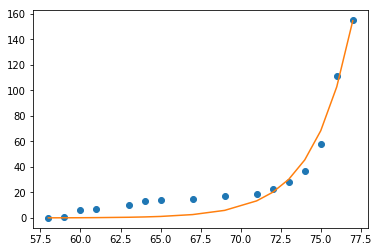

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [17]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en millones):

In [18]:
results['total_infected']/1e6

15.591512116535618

In [19]:
results['total_infected']-errors_dict['c_err']

-893504025549.1771

El pico de infección se obtiene para el día:

In [20]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

151

La fecha esperada para el pico de infección es:

In [21]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:5 día: 31


Cuántos casos se espera para hoy?

In [22]:
dt = datetime.today()
target_date = datetime(dt.year, dt.month, dt.day)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-03-23 00:00:00 corresponde al día 82 con respecto al 01/01/20
Predicción del número de infecciones: 1189.5344482111673


Para la fecha de máxima infecciones, cuántas infecciones?

In [23]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)/1e6
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 15.591511995729325


## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

In [24]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%b %d')
target_date = datetime(2020, 4, 13)
initial_date = datetime(2020, 1, 1)
x_end = (target_date-initial_date).days
x_pronos = np.arange(start=x[0], stop=x_end, step=1)
y_pronos = logistic_model(x_pronos, *popt)/1e6

## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

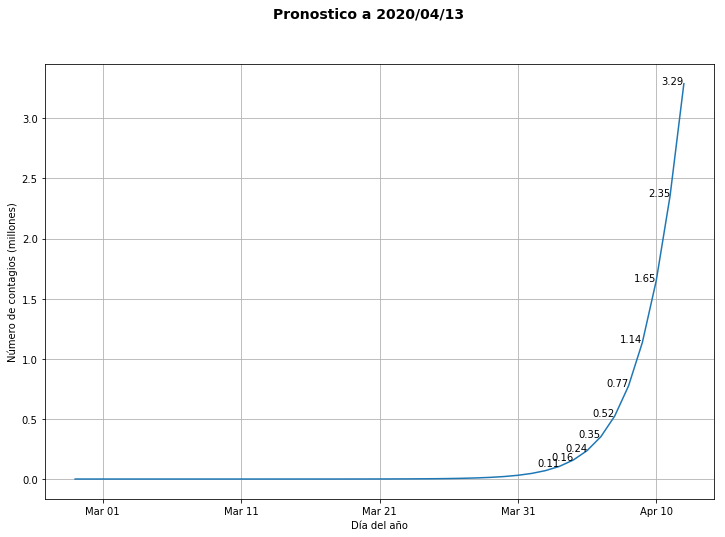

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.suptitle('Pronostico a 2020/04/13', fontsize=14, fontweight='bold')
ax.plot(x_pronos, y_pronos, '-')
for xi,yi in zip(x_pronos,y_pronos):
    if yi>0.1:
        ax.text(xi-0.8, yi, "%.2f" %yi, ha='center')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Día del año')
ax.set_ylabel('Número de contagios (millones)')
ax.grid(True)
fig.savefig('images/proyectionApril13.png')

<center>
<img src="images/proyectionApril13.png"/>
</center>

Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.

## Conclusiones
* Quédate en la casa. Al momento los datos indicarían que estamos subiendo por la curva de infección en el primer estadio. 
* Es necesario relantizar dicha pendiente para no colapsar los sistemas médicos.
* Es necesario que las autoridades y otros sectores involucrados traten de proveerse de insumos médicos adicionales. A más de las máscaras, debería observarse la necesidad de respiradores artificiales.

## Conclusiones

* Si consideramos que la población del Ecuador es de 17 millones (https://countrymeters.info/es/Ecuador), 15 millones de contagiados, en la situación sin restricción de movilidad, implica un contagio del **89%**, estimando alcanzar el pico en 93 días más.

* Los cálculos aquí presentados son referenciales en función de la información disponible y de los modelos presentados. Dado que los factores de restricción de movilidad ya están en ejecución se esperaría que el número de infectados sea menor. Esta es una aproximación simplista del escenario. 


In [26]:
population = 17368483
rate = results['total_infected']/population*100.0
print(rate)
days_remaining = sol-df['Date'].iloc[0]
print(days_remaining)

89.76899201004267
93


### Artificial Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [28]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(1e-4), metrics=['mae', 'mse'])
    return model

model = baseline_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)  

In [29]:
x_stats = df["Date"].describe()
x_stats

count    16.000000
mean     67.750000
std       6.454972
min      58.000000
25%      62.500000
50%      68.000000
75%      73.250000
max      77.000000
Name: Date, dtype: float64

In [30]:
y_stats = df["Number_of_Cases"].describe()
y_stats

count     16.000000
mean      32.125000
std       42.665951
min        0.000000
25%        9.250000
50%       16.000000
75%       30.250000
max      155.000000
Name: Number_of_Cases, dtype: float64

In [31]:
x_norm = (np.array(x)-x_stats['mean'])/x_stats['std']
x_norm

array([-1.51046351, -1.35554417, -1.20062484, -1.0457055 , -0.73586684,
       -0.5809475 , -0.42602817, -0.1161895 ,  0.19364917,  0.50348784,
        0.65840717,  0.8133265 ,  0.96824584,  1.12316517,  1.2780845 ,
        1.43300384])

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
y_ = np.array(y)
results = cross_val_score(estimator, x_norm, y_, cv=kfold)
print("baseline: {} mse {}".format(results.mean(), results.std()))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 3125.6836 - mean_absolute_error: 36.6144 - mean_squared_error: 3125.6836
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 3115.5495 - mean_absolute_error: 36.5119 - mean_squared_error: 3115.5495
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 3104.4748 - mean_absolute_error: 36.4050 - mean_squared_error: 3104.4748
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 3095.0684 - mean_absolute_error: 36.2676 - mean_squared_error: 3095.0684
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 3074.7198 - mean_absolute_error: 36.1043 - mean_squared_error: 3074.7198
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 3054.3496 - mean_absolute_error: 35.8790 - mean_squared_error: 3054.3496
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 302

14/14 [==============================] - 0s 4ms/step - loss: 2903.6176 - mean_absolute_error: 34.3398 - mean_squared_error: 2903.6176
Epoch 12/100
14/14 [==============================] - 0s 5ms/step - loss: 2852.1785 - mean_absolute_error: 33.8943 - mean_squared_error: 2852.1785
Epoch 13/100
14/14 [==============================] - 0s 4ms/step - loss: 2788.8858 - mean_absolute_error: 33.3186 - mean_squared_error: 2788.8858
Epoch 14/100
14/14 [==============================] - 0s 4ms/step - loss: 2712.2451 - mean_absolute_error: 32.9187 - mean_squared_error: 2712.2451
Epoch 15/100
14/14 [==============================] - 0s 4ms/step - loss: 2611.6797 - mean_absolute_error: 32.2042 - mean_squared_error: 2611.6797
Epoch 16/100
14/14 [==============================] - 0s 4ms/step - loss: 2536.7645 - mean_absolute_error: 31.3556 - mean_squared_error: 2536.7645
Epoch 17/100
14/14 [==============================] - 0s 5ms/step - loss: 2431.0822 - mean_absolute_error: 30.5887 - mean_squared_e

Epoch 23/100
14/14 [==============================] - 0s 4ms/step - loss: 1584.7933 - mean_absolute_error: 22.0017 - mean_squared_error: 1584.7933
Epoch 24/100
14/14 [==============================] - 0s 4ms/step - loss: 1465.9361 - mean_absolute_error: 20.1244 - mean_squared_error: 1465.9361
Epoch 25/100
14/14 [==============================] - 0s 4ms/step - loss: 1344.3757 - mean_absolute_error: 19.0045 - mean_squared_error: 1344.3757
Epoch 26/100
14/14 [==============================] - 0s 4ms/step - loss: 1248.7107 - mean_absolute_error: 18.0112 - mean_squared_error: 1248.7107
Epoch 27/100
14/14 [==============================] - 0s 8ms/step - loss: 1120.3290 - mean_absolute_error: 17.2598 - mean_squared_error: 1120.3290
Epoch 28/100
14/14 [==============================] - 0s 5ms/step - loss: 1014.7824 - mean_absolute_error: 17.0550 - mean_squared_error: 1014.7824
Epoch 29/100
14/14 [==============================] - 0s 5ms/step - loss: 849.1062 - mean_absolute_error: 16.5404 - me

14/14 [==============================] - 0s 10ms/step - loss: 637.6853 - mean_absolute_error: 16.9205 - mean_squared_error: 637.6853
Epoch 35/100
14/14 [==============================] - 0s 6ms/step - loss: 565.2071 - mean_absolute_error: 17.2021 - mean_squared_error: 565.2071
Epoch 36/100
14/14 [==============================] - 0s 6ms/step - loss: 611.2267 - mean_absolute_error: 18.1504 - mean_squared_error: 611.2267
Epoch 37/100
14/14 [==============================] - 0s 6ms/step - loss: 621.5446 - mean_absolute_error: 17.2999 - mean_squared_error: 621.5446
Epoch 38/100
14/14 [==============================] - 0s 9ms/step - loss: 642.7987 - mean_absolute_error: 18.5630 - mean_squared_error: 642.7987
Epoch 39/100
14/14 [==============================] - 0s 5ms/step - loss: 550.3707 - mean_absolute_error: 16.9489 - mean_squared_error: 550.3707
Epoch 40/100
14/14 [==============================] - 0s 4ms/step - loss: 563.2016 - mean_absolute_error: 17.0941 - mean_squared_error: 563.20

14/14 [==============================] - 0s 4ms/step - loss: 614.5610 - mean_absolute_error: 17.4909 - mean_squared_error: 614.5610
Epoch 46/100
14/14 [==============================] - 0s 10ms/step - loss: 552.7658 - mean_absolute_error: 16.9543 - mean_squared_error: 552.7658
Epoch 47/100
14/14 [==============================] - 0s 4ms/step - loss: 517.8414 - mean_absolute_error: 16.7372 - mean_squared_error: 517.8414
Epoch 48/100
14/14 [==============================] - 0s 4ms/step - loss: 569.1061 - mean_absolute_error: 17.5585 - mean_squared_error: 569.1061
Epoch 49/100
14/14 [==============================] - 0s 3ms/step - loss: 638.6211 - mean_absolute_error: 17.3793 - mean_squared_error: 638.6211
Epoch 50/100
14/14 [==============================] - 0s 3ms/step - loss: 582.9743 - mean_absolute_error: 16.7633 - mean_squared_error: 582.9743
Epoch 51/100
14/14 [==============================] - 0s 3ms/step - loss: 547.8320 - mean_absolute_error: 16.5145 - mean_squared_error: 547.83

14/14 [==============================] - 0s 4ms/step - loss: 475.6971 - mean_absolute_error: 14.9665 - mean_squared_error: 475.6971
Epoch 56/100
14/14 [==============================] - 0s 4ms/step - loss: 445.2793 - mean_absolute_error: 15.0405 - mean_squared_error: 445.2793
Epoch 57/100
14/14 [==============================] - 0s 9ms/step - loss: 421.0804 - mean_absolute_error: 14.1965 - mean_squared_error: 421.0804
Epoch 58/100
14/14 [==============================] - 0s 4ms/step - loss: 440.6463 - mean_absolute_error: 14.7166 - mean_squared_error: 440.6463
Epoch 59/100
14/14 [==============================] - 0s 6ms/step - loss: 421.2624 - mean_absolute_error: 13.8816 - mean_squared_error: 421.2624
Epoch 60/100
14/14 [==============================] - 0s 6ms/step - loss: 500.7786 - mean_absolute_error: 15.1040 - mean_squared_error: 500.7786
Epoch 61/100
14/14 [==============================] - 0s 4ms/step - loss: 497.2283 - mean_absolute_error: 14.9391 - mean_squared_error: 497.228

15/15 [==============================] - 0s 11ms/step - loss: 466.4767 - mean_absolute_error: 14.8797 - mean_squared_error: 466.4767
Epoch 66/100
15/15 [==============================] - 0s 9ms/step - loss: 525.4825 - mean_absolute_error: 15.6612 - mean_squared_error: 525.4825
Epoch 67/100
15/15 [==============================] - 0s 8ms/step - loss: 523.8204 - mean_absolute_error: 16.0290 - mean_squared_error: 523.8204
Epoch 68/100
15/15 [==============================] - 0s 14ms/step - loss: 422.5494 - mean_absolute_error: 14.9097 - mean_squared_error: 422.5494
Epoch 69/100
15/15 [==============================] - 0s 6ms/step - loss: 445.8917 - mean_absolute_error: 14.8293 - mean_squared_error: 445.8917
Epoch 70/100
15/15 [==============================] - 0s 13ms/step - loss: 434.1513 - mean_absolute_error: 14.8068 - mean_squared_error: 434.1513
Epoch 71/100
15/15 [==============================] - 0s 5ms/step - loss: 408.0008 - mean_absolute_error: 14.3164 - mean_squared_error: 408.

15/15 [==============================] - 0s 10ms/step - loss: 479.0044 - mean_absolute_error: 15.4606 - mean_squared_error: 479.0044
Epoch 77/100
15/15 [==============================] - 0s 14ms/step - loss: 487.5350 - mean_absolute_error: 15.6537 - mean_squared_error: 487.5350
Epoch 78/100
15/15 [==============================] - 0s 11ms/step - loss: 529.0420 - mean_absolute_error: 15.6295 - mean_squared_error: 529.0420
Epoch 79/100
15/15 [==============================] - 0s 5ms/step - loss: 423.1541 - mean_absolute_error: 15.0161 - mean_squared_error: 423.1541
Epoch 80/100
15/15 [==============================] - 0s 4ms/step - loss: 507.7059 - mean_absolute_error: 15.7899 - mean_squared_error: 507.7059
Epoch 81/100
15/15 [==============================] - 0s 4ms/step - loss: 529.7257 - mean_absolute_error: 15.6882 - mean_squared_error: 529.7257
Epoch 82/100
15/15 [==============================] - 0s 16ms/step - loss: 518.9195 - mean_absolute_error: 15.8682 - mean_squared_error: 518

15/15 [==============================] - 0s 10ms/step - loss: 512.2154 - mean_absolute_error: 13.8189 - mean_squared_error: 512.2154
Epoch 88/100
15/15 [==============================] - 0s 7ms/step - loss: 462.2463 - mean_absolute_error: 14.1197 - mean_squared_error: 462.2463
Epoch 89/100
15/15 [==============================] - 0s 4ms/step - loss: 521.4849 - mean_absolute_error: 13.8739 - mean_squared_error: 521.4849
Epoch 90/100
15/15 [==============================] - 0s 3ms/step - loss: 452.6386 - mean_absolute_error: 13.6955 - mean_squared_error: 452.6386
Epoch 91/100
15/15 [==============================] - 0s 4ms/step - loss: 484.4562 - mean_absolute_error: 13.4923 - mean_squared_error: 484.4562
Epoch 92/100
15/15 [==============================] - 0s 4ms/step - loss: 487.8237 - mean_absolute_error: 13.4199 - mean_squared_error: 487.8237
Epoch 93/100
15/15 [==============================] - 0s 3ms/step - loss: 414.2067 - mean_absolute_error: 12.6900 - mean_squared_error: 414.20

15/15 [==============================] - 0s 6ms/step - loss: 221.5940 - mean_absolute_error: 9.5451 - mean_squared_error: 221.5940
Epoch 99/100
15/15 [==============================] - 0s 9ms/step - loss: 185.6317 - mean_absolute_error: 8.5475 - mean_squared_error: 185.6317
Epoch 100/100
1/1 [==============================] - 0s 284ms/step
baseline: -1078.1677798569203 mse 1796.9063755420582


In [33]:
y_reg = model.predict(x_norm.reshape(-1,1))
y_reg

array([[0.0240762 ],
       [0.02160685],
       [0.01913751],
       [0.01666813],
       [0.01172944],
       [0.00926007],
       [0.00679072],
       [0.00185201],
       [0.00190037],
       [0.00494098],
       [0.00646127],
       [0.00798156],
       [0.00950186],
       [0.01102218],
       [0.01254246],
       [0.01406279]], dtype=float32)

In [34]:
# from sklearn.model_selection import train_test_split
# x_ = np.array(x)
# y_ = np.array(y)
# x_train, x_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42, shuffle=True)
# print('Numero de casos de entrenamiento: {}'.format(len(x_train)))
# print('Numero de casos de testeo: {}'.format(len(x_test)))
# print("x: {}".format(x_))
# print("y: {}".format(y_))
# print("x_train: {}".format(x_train))
# print("y_train: {}".format(y_train))
# print("x_test: {}".format(x_test))
# print("y_test: {}".format(y_test))
      

In [35]:
history = model.fit(x_norm, y, verbose=1, epochs=1500)

Epoch 1/1500
16/16 [==============================] - 2s 95ms/step - loss: 2737.8364 - mean_absolute_error: 32.1174 - mean_squared_error: 2737.8364
Epoch 2/1500
16/16 [==============================] - 0s 1ms/step - loss: 2732.7468 - mean_absolute_error: 32.0633 - mean_squared_error: 2732.7468
Epoch 3/1500
16/16 [==============================] - 0s 1ms/step - loss: 2728.0107 - mean_absolute_error: 32.0211 - mean_squared_error: 2728.0107
Epoch 4/1500
16/16 [==============================] - 0s 1ms/step - loss: 2723.6719 - mean_absolute_error: 31.9693 - mean_squared_error: 2723.6719
Epoch 5/1500
16/16 [==============================] - 0s 1ms/step - loss: 2721.1233 - mean_absolute_error: 31.9448 - mean_squared_error: 2721.1233
Epoch 6/1500
16/16 [==============================] - 0s 1ms/step - loss: 2713.6714 - mean_absolute_error: 31.8757 - mean_squared_error: 2713.6714
Epoch 7/1500
16/16 [==============================] - 0s 2ms/step - loss: 2709.5825 - mean_absolute_error: 31.8183 - 

Epoch 57/1500
16/16 [==============================] - 0s 4ms/step - loss: 898.9854 - mean_absolute_error: 15.1954 - mean_squared_error: 898.9854
Epoch 58/1500
16/16 [==============================] - 0s 2ms/step - loss: 790.2034 - mean_absolute_error: 15.0000 - mean_squared_error: 790.2034
Epoch 59/1500
16/16 [==============================] - 0s 1ms/step - loss: 752.6511 - mean_absolute_error: 14.7802 - mean_squared_error: 752.6511
Epoch 60/1500
16/16 [==============================] - 0s 1ms/step - loss: 785.6849 - mean_absolute_error: 15.0403 - mean_squared_error: 785.6849
Epoch 61/1500
16/16 [==============================] - 0s 2ms/step - loss: 711.2843 - mean_absolute_error: 14.7801 - mean_squared_error: 711.2843
Epoch 62/1500
16/16 [==============================] - 0s 2ms/step - loss: 682.1406 - mean_absolute_error: 15.0177 - mean_squared_error: 682.1406
Epoch 63/1500
16/16 [==============================] - 0s 2ms/step - loss: 702.1154 - mean_absolute_error: 15.3006 - mean_sq

16/16 [==============================] - 0s 2ms/step - loss: 485.8883 - mean_absolute_error: 15.3224 - mean_squared_error: 485.8883
Epoch 114/1500
16/16 [==============================] - 0s 4ms/step - loss: 486.8438 - mean_absolute_error: 15.4710 - mean_squared_error: 486.8438
Epoch 115/1500
16/16 [==============================] - 0s 2ms/step - loss: 489.0142 - mean_absolute_error: 15.2898 - mean_squared_error: 489.0142
Epoch 116/1500
16/16 [==============================] - 0s 3ms/step - loss: 422.5746 - mean_absolute_error: 14.6851 - mean_squared_error: 422.5746
Epoch 117/1500
16/16 [==============================] - 0s 1ms/step - loss: 463.0286 - mean_absolute_error: 14.9603 - mean_squared_error: 463.0286
Epoch 118/1500
16/16 [==============================] - 0s 1ms/step - loss: 411.6711 - mean_absolute_error: 14.5421 - mean_squared_error: 411.6711
Epoch 119/1500
16/16 [==============================] - 0s 1ms/step - loss: 430.9924 - mean_absolute_error: 14.7060 - mean_squared_er

Epoch 169/1500
16/16 [==============================] - 0s 1ms/step - loss: 379.0493 - mean_absolute_error: 12.9478 - mean_squared_error: 379.0493
Epoch 170/1500
16/16 [==============================] - 0s 1ms/step - loss: 351.4914 - mean_absolute_error: 12.5957 - mean_squared_error: 351.4914
Epoch 171/1500
16/16 [==============================] - 0s 1ms/step - loss: 436.6946 - mean_absolute_error: 13.5869 - mean_squared_error: 436.6946
Epoch 172/1500
16/16 [==============================] - 0s 937us/step - loss: 440.2776 - mean_absolute_error: 13.2987 - mean_squared_error: 440.2776
Epoch 173/1500
16/16 [==============================] - 0s 1ms/step - loss: 383.7916 - mean_absolute_error: 12.8605 - mean_squared_error: 383.7916
Epoch 174/1500
16/16 [==============================] - 0s 1ms/step - loss: 418.8032 - mean_absolute_error: 13.0991 - mean_squared_error: 418.8032
Epoch 175/1500
16/16 [==============================] - 0s 5ms/step - loss: 417.8343 - mean_absolute_error: 13.6621 

Epoch 225/1500
16/16 [==============================] - 0s 5ms/step - loss: 343.2184 - mean_absolute_error: 11.7378 - mean_squared_error: 343.2184
Epoch 226/1500
16/16 [==============================] - 0s 3ms/step - loss: 303.9649 - mean_absolute_error: 11.2318 - mean_squared_error: 303.9649
Epoch 227/1500
16/16 [==============================] - 0s 4ms/step - loss: 329.9455 - mean_absolute_error: 12.0492 - mean_squared_error: 329.9455
Epoch 228/1500
16/16 [==============================] - 0s 4ms/step - loss: 373.4948 - mean_absolute_error: 12.4264 - mean_squared_error: 373.4948
Epoch 229/1500
16/16 [==============================] - 0s 3ms/step - loss: 293.2533 - mean_absolute_error: 11.0884 - mean_squared_error: 293.2533
Epoch 230/1500
16/16 [==============================] - 0s 3ms/step - loss: 299.1932 - mean_absolute_error: 11.1083 - mean_squared_error: 299.1932
Epoch 231/1500
16/16 [==============================] - 0s 2ms/step - loss: 316.3316 - mean_absolute_error: 11.5844 - 

Epoch 281/1500
16/16 [==============================] - 0s 2ms/step - loss: 254.5550 - mean_absolute_error: 10.1831 - mean_squared_error: 254.5550
Epoch 282/1500
16/16 [==============================] - 0s 1ms/step - loss: 253.3142 - mean_absolute_error: 10.1403 - mean_squared_error: 253.3142
Epoch 283/1500
16/16 [==============================] - 0s 6ms/step - loss: 272.7291 - mean_absolute_error: 10.2549 - mean_squared_error: 272.7291
Epoch 284/1500
16/16 [==============================] - 0s 6ms/step - loss: 206.9664 - mean_absolute_error: 9.5311 - mean_squared_error: 206.9664
Epoch 285/1500
16/16 [==============================] - 0s 3ms/step - loss: 285.5955 - mean_absolute_error: 10.2626 - mean_squared_error: 285.5955
Epoch 286/1500
16/16 [==============================] - 0s 1ms/step - loss: 200.5633 - mean_absolute_error: 9.4410 - mean_squared_error: 200.5633
Epoch 287/1500
16/16 [==============================] - 0s 2ms/step - loss: 297.1668 - mean_absolute_error: 10.2658 - me

Epoch 338/1500
16/16 [==============================] - 0s 2ms/step - loss: 109.7523 - mean_absolute_error: 6.9361 - mean_squared_error: 109.7523
Epoch 339/1500
16/16 [==============================] - 0s 1ms/step - loss: 154.4407 - mean_absolute_error: 7.3092 - mean_squared_error: 154.4407
Epoch 340/1500
16/16 [==============================] - 0s 1ms/step - loss: 129.7719 - mean_absolute_error: 7.3717 - mean_squared_error: 129.7719
Epoch 341/1500
16/16 [==============================] - 0s 1ms/step - loss: 126.4858 - mean_absolute_error: 6.9232 - mean_squared_error: 126.4858
Epoch 342/1500
16/16 [==============================] - 0s 995us/step - loss: 141.6437 - mean_absolute_error: 7.1830 - mean_squared_error: 141.6437
Epoch 343/1500
16/16 [==============================] - 0s 1ms/step - loss: 105.5876 - mean_absolute_error: 6.6021 - mean_squared_error: 105.5876
Epoch 344/1500
16/16 [==============================] - 0s 1ms/step - loss: 120.8023 - mean_absolute_error: 6.5995 - mean_

Epoch 395/1500
16/16 [==============================] - 0s 1ms/step - loss: 65.1086 - mean_absolute_error: 4.9987 - mean_squared_error: 65.1086
Epoch 396/1500
16/16 [==============================] - 0s 1ms/step - loss: 38.0823 - mean_absolute_error: 4.1979 - mean_squared_error: 38.0823
Epoch 397/1500
16/16 [==============================] - 0s 3ms/step - loss: 63.3570 - mean_absolute_error: 4.6213 - mean_squared_error: 63.3570
Epoch 398/1500
16/16 [==============================] - 0s 6ms/step - loss: 30.9230 - mean_absolute_error: 3.4607 - mean_squared_error: 30.9230
Epoch 399/1500
16/16 [==============================] - 0s 4ms/step - loss: 52.1692 - mean_absolute_error: 4.4355 - mean_squared_error: 52.1692
Epoch 400/1500
16/16 [==============================] - 0s 2ms/step - loss: 45.6176 - mean_absolute_error: 3.8402 - mean_squared_error: 45.6176
Epoch 401/1500
16/16 [==============================] - 0s 1ms/step - loss: 36.4967 - mean_absolute_error: 3.7272 - mean_squared_error: 

Epoch 452/1500
16/16 [==============================] - 0s 5ms/step - loss: 37.7340 - mean_absolute_error: 3.4589 - mean_squared_error: 37.7340
Epoch 453/1500
16/16 [==============================] - 0s 4ms/step - loss: 27.1138 - mean_absolute_error: 3.7553 - mean_squared_error: 27.1138
Epoch 454/1500
16/16 [==============================] - 0s 6ms/step - loss: 17.8125 - mean_absolute_error: 2.9395 - mean_squared_error: 17.8125
Epoch 455/1500
16/16 [==============================] - 0s 3ms/step - loss: 20.8711 - mean_absolute_error: 2.8972 - mean_squared_error: 20.8711
Epoch 456/1500
16/16 [==============================] - 0s 2ms/step - loss: 14.2269 - mean_absolute_error: 2.2645 - mean_squared_error: 14.2269
Epoch 457/1500
16/16 [==============================] - 0s 2ms/step - loss: 26.6553 - mean_absolute_error: 2.7230 - mean_squared_error: 26.6553
Epoch 458/1500
16/16 [==============================] - 0s 1ms/step - loss: 8.3149 - mean_absolute_error: 1.7651 - mean_squared_error: 8

Epoch 510/1500
16/16 [==============================] - 0s 1ms/step - loss: 14.2532 - mean_absolute_error: 2.4417 - mean_squared_error: 14.2532
Epoch 511/1500
16/16 [==============================] - 0s 1ms/step - loss: 9.3511 - mean_absolute_error: 2.1410 - mean_squared_error: 9.3511
Epoch 512/1500
16/16 [==============================] - 0s 1ms/step - loss: 10.5886 - mean_absolute_error: 2.0727 - mean_squared_error: 10.5886
Epoch 513/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.6667 - mean_absolute_error: 1.6025 - mean_squared_error: 3.6667
Epoch 514/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.9288 - mean_absolute_error: 1.7415 - mean_squared_error: 6.9288
Epoch 515/1500
16/16 [==============================] - 0s 1ms/step - loss: 11.3013 - mean_absolute_error: 1.9852 - mean_squared_error: 11.3013
Epoch 516/1500
16/16 [==============================] - 0s 1ms/step - loss: 9.2553 - mean_absolute_error: 1.8802 - mean_squared_error: 9.2553


Epoch 568/1500
16/16 [==============================] - 0s 6ms/step - loss: 8.8228 - mean_absolute_error: 1.8208 - mean_squared_error: 8.8228
Epoch 569/1500
16/16 [==============================] - 0s 3ms/step - loss: 12.1318 - mean_absolute_error: 1.9333 - mean_squared_error: 12.1318
Epoch 570/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.2061 - mean_absolute_error: 1.2458 - mean_squared_error: 3.2061
Epoch 571/1500
16/16 [==============================] - 0s 2ms/step - loss: 7.5961 - mean_absolute_error: 1.9647 - mean_squared_error: 7.5961
Epoch 572/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.1051 - mean_absolute_error: 2.5021 - mean_squared_error: 13.1051
Epoch 573/1500
16/16 [==============================] - 0s 1ms/step - loss: 28.1887 - mean_absolute_error: 3.7451 - mean_squared_error: 28.1887
Epoch 574/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.1832 - mean_absolute_error: 1.8992 - mean_squared_error: 5.1832


Epoch 626/1500
16/16 [==============================] - 0s 1ms/step - loss: 23.7051 - mean_absolute_error: 2.5239 - mean_squared_error: 23.7051
Epoch 627/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.4015 - mean_absolute_error: 1.4055 - mean_squared_error: 3.4015
Epoch 628/1500
16/16 [==============================] - 0s 2ms/step - loss: 1.2180 - mean_absolute_error: 0.8167 - mean_squared_error: 1.2180
Epoch 629/1500
16/16 [==============================] - 0s 5ms/step - loss: 2.5884 - mean_absolute_error: 1.3257 - mean_squared_error: 2.5884
Epoch 630/1500
16/16 [==============================] - 0s 2ms/step - loss: 19.2842 - mean_absolute_error: 2.2097 - mean_squared_error: 19.2842
Epoch 631/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.2855 - mean_absolute_error: 1.9642 - mean_squared_error: 7.2855
Epoch 632/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.1341 - mean_absolute_error: 2.3483 - mean_squared_error: 8.1341
Ep

Epoch 684/1500
16/16 [==============================] - 0s 1ms/step - loss: 7.5837 - mean_absolute_error: 1.7399 - mean_squared_error: 7.5837
Epoch 685/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.1571 - mean_absolute_error: 1.4215 - mean_squared_error: 5.1571
Epoch 686/1500
16/16 [==============================] - 0s 1ms/step - loss: 23.4748 - mean_absolute_error: 2.0703 - mean_squared_error: 23.4748
Epoch 687/1500
16/16 [==============================] - 0s 2ms/step - loss: 10.2412 - mean_absolute_error: 2.2480 - mean_squared_error: 10.2412
Epoch 688/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.4955 - mean_absolute_error: 1.7606 - mean_squared_error: 6.4955
Epoch 689/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.1110 - mean_absolute_error: 1.9972 - mean_squared_error: 8.1110
Epoch 690/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.6369 - mean_absolute_error: 2.2974 - mean_squared_error: 9.6369
Ep

Epoch 742/1500
16/16 [==============================] - 0s 3ms/step - loss: 5.8715 - mean_absolute_error: 1.6309 - mean_squared_error: 5.8715
Epoch 743/1500
16/16 [==============================] - 0s 3ms/step - loss: 1.6004 - mean_absolute_error: 0.9196 - mean_squared_error: 1.6004
Epoch 744/1500
16/16 [==============================] - 0s 1ms/step - loss: 1.8610 - mean_absolute_error: 1.0208 - mean_squared_error: 1.8610
Epoch 745/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.5245 - mean_absolute_error: 1.5271 - mean_squared_error: 4.5245
Epoch 746/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.3900 - mean_absolute_error: 1.8637 - mean_squared_error: 9.3900
Epoch 747/1500
16/16 [==============================] - 0s 3ms/step - loss: 10.9093 - mean_absolute_error: 2.0996 - mean_squared_error: 10.9093
Epoch 748/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.3216 - mean_absolute_error: 1.9473 - mean_squared_error: 5.3216
Epoc

Epoch 800/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.8546 - mean_absolute_error: 1.7863 - mean_squared_error: 8.8546
Epoch 801/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.0937 - mean_absolute_error: 1.3873 - mean_squared_error: 3.0937
Epoch 802/1500
16/16 [==============================] - 0s 4ms/step - loss: 12.1163 - mean_absolute_error: 2.5400 - mean_squared_error: 12.1163
Epoch 803/1500
16/16 [==============================] - 0s 5ms/step - loss: 12.6638 - mean_absolute_error: 2.3083 - mean_squared_error: 12.6638
Epoch 804/1500
16/16 [==============================] - 0s 5ms/step - loss: 9.7103 - mean_absolute_error: 2.0294 - mean_squared_error: 9.7103
Epoch 805/1500
16/16 [==============================] - 0s 6ms/step - loss: 15.6575 - mean_absolute_error: 2.0616 - mean_squared_error: 15.6575
Epoch 806/1500
16/16 [==============================] - 0s 4ms/step - loss: 9.7462 - mean_absolute_error: 2.0354 - mean_squared_error: 9.7462


Epoch 858/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.4815 - mean_absolute_error: 1.2112 - mean_squared_error: 2.4815
Epoch 859/1500
16/16 [==============================] - 0s 2ms/step - loss: 7.1031 - mean_absolute_error: 1.6040 - mean_squared_error: 7.1031
Epoch 860/1500
16/16 [==============================] - 0s 2ms/step - loss: 1.3249 - mean_absolute_error: 0.9210 - mean_squared_error: 1.3249
Epoch 861/1500
16/16 [==============================] - 0s 2ms/step - loss: 12.6064 - mean_absolute_error: 1.7397 - mean_squared_error: 12.6064
Epoch 862/1500
16/16 [==============================] - 0s 1ms/step - loss: 26.9070 - mean_absolute_error: 3.0064 - mean_squared_error: 26.9070
Epoch 863/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.3340 - mean_absolute_error: 1.7809 - mean_squared_error: 6.3340
Epoch 864/1500
16/16 [==============================] - 0s 5ms/step - loss: 6.4452 - mean_absolute_error: 1.8548 - mean_squared_error: 6.4452
Ep

Epoch 916/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.2876 - mean_absolute_error: 1.5088 - mean_squared_error: 3.2876
Epoch 917/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.8854 - mean_absolute_error: 1.2200 - mean_squared_error: 2.8854
Epoch 918/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.4033 - mean_absolute_error: 2.2751 - mean_squared_error: 11.4033
Epoch 919/1500
16/16 [==============================] - 0s 4ms/step - loss: 11.2361 - mean_absolute_error: 1.9005 - mean_squared_error: 11.2361
Epoch 920/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.6148 - mean_absolute_error: 1.4175 - mean_squared_error: 3.6148
Epoch 921/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.4484 - mean_absolute_error: 1.9138 - mean_squared_error: 9.4484
Epoch 922/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.2548 - mean_absolute_error: 1.2482 - mean_squared_error: 2.2548
Ep

Epoch 974/1500
16/16 [==============================] - 0s 1ms/step - loss: 30.8466 - mean_absolute_error: 3.5375 - mean_squared_error: 30.8466
Epoch 975/1500
16/16 [==============================] - 0s 1ms/step - loss: 10.4979 - mean_absolute_error: 2.4213 - mean_squared_error: 10.4979
Epoch 976/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.5722 - mean_absolute_error: 1.6373 - mean_squared_error: 5.5722
Epoch 977/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.5192 - mean_absolute_error: 1.0852 - mean_squared_error: 2.5192
Epoch 978/1500
16/16 [==============================] - 0s 6ms/step - loss: 9.2180 - mean_absolute_error: 1.6962 - mean_squared_error: 9.2180
Epoch 979/1500
16/16 [==============================] - 0s 3ms/step - loss: 0.7415 - mean_absolute_error: 0.7274 - mean_squared_error: 0.7415
Epoch 980/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.8363 - mean_absolute_error: 1.4877 - mean_squared_error: 5.8363
Ep

Epoch 1032/1500
16/16 [==============================] - 0s 3ms/step - loss: 7.5436 - mean_absolute_error: 1.8028 - mean_squared_error: 7.5436
Epoch 1033/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.1211 - mean_absolute_error: 1.9776 - mean_squared_error: 11.1211
Epoch 1034/1500
16/16 [==============================] - 0s 1ms/step - loss: 14.0652 - mean_absolute_error: 2.2765 - mean_squared_error: 14.0652
Epoch 1035/1500
16/16 [==============================] - 0s 2ms/step - loss: 12.0076 - mean_absolute_error: 2.0743 - mean_squared_error: 12.0076
Epoch 1036/1500
16/16 [==============================] - 0s 1ms/step - loss: 20.6351 - mean_absolute_error: 2.5348 - mean_squared_error: 20.6351
Epoch 1037/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.4506 - mean_absolute_error: 1.8460 - mean_squared_error: 6.4506
Epoch 1038/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.3061 - mean_absolute_error: 1.7753 - mean_squared_error

Epoch 1089/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.5628 - mean_absolute_error: 2.0703 - mean_squared_error: 11.5628
Epoch 1090/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.4292 - mean_absolute_error: 1.6425 - mean_squared_error: 6.4292
Epoch 1091/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.2716 - mean_absolute_error: 1.0516 - mean_squared_error: 2.2716
Epoch 1092/1500
16/16 [==============================] - 0s 6ms/step - loss: 1.2225 - mean_absolute_error: 0.7643 - mean_squared_error: 1.2225
Epoch 1093/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.7248 - mean_absolute_error: 1.4296 - mean_squared_error: 3.7248
Epoch 1094/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.2608 - mean_absolute_error: 1.6352 - mean_squared_error: 6.2608
Epoch 1095/1500
16/16 [==============================] - 0s 3ms/step - loss: 23.1105 - mean_absolute_error: 3.0655 - mean_squared_error: 23.

16/16 [==============================] - 0s 2ms/step - loss: 0.9553 - mean_absolute_error: 0.8308 - mean_squared_error: 0.9553
Epoch 1147/1500
16/16 [==============================] - 0s 2ms/step - loss: 7.1056 - mean_absolute_error: 1.4271 - mean_squared_error: 7.1056
Epoch 1148/1500
16/16 [==============================] - 0s 1ms/step - loss: 12.4246 - mean_absolute_error: 2.1433 - mean_squared_error: 12.4246
Epoch 1149/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.5809 - mean_absolute_error: 1.8340 - mean_squared_error: 6.5809
Epoch 1150/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.4032 - mean_absolute_error: 1.1974 - mean_squared_error: 3.4032
Epoch 1151/1500
16/16 [==============================] - 0s 7ms/step - loss: 12.9751 - mean_absolute_error: 2.0230 - mean_squared_error: 12.9751
Epoch 1152/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.7036 - mean_absolute_error: 1.9271 - mean_squared_error: 7.7036
Epoch 1153/

Epoch 1204/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.7837 - mean_absolute_error: 2.4770 - mean_squared_error: 17.7837
Epoch 1205/1500
16/16 [==============================] - 0s 5ms/step - loss: 16.7032 - mean_absolute_error: 2.3539 - mean_squared_error: 16.7032
Epoch 1206/1500
16/16 [==============================] - 0s 2ms/step - loss: 12.4037 - mean_absolute_error: 2.2716 - mean_squared_error: 12.4037
Epoch 1207/1500
16/16 [==============================] - 0s 4ms/step - loss: 1.9882 - mean_absolute_error: 1.0922 - mean_squared_error: 1.9882
Epoch 1208/1500
16/16 [==============================] - 0s 3ms/step - loss: 5.4523 - mean_absolute_error: 1.6121 - mean_squared_error: 5.4523
Epoch 1209/1500
16/16 [==============================] - 0s 2ms/step - loss: 7.8609 - mean_absolute_error: 2.0040 - mean_squared_error: 7.8609
Epoch 1210/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.5075 - mean_absolute_error: 2.1753 - mean_squared_error: 

Epoch 1261/1500
16/16 [==============================] - 0s 5ms/step - loss: 28.8999 - mean_absolute_error: 3.4312 - mean_squared_error: 28.8999
Epoch 1262/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.3578 - mean_absolute_error: 2.2791 - mean_squared_error: 8.3578
Epoch 1263/1500
16/16 [==============================] - 0s 2ms/step - loss: 4.6446 - mean_absolute_error: 1.6016 - mean_squared_error: 4.6446
Epoch 1264/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.2739 - mean_absolute_error: 1.0990 - mean_squared_error: 2.2739
Epoch 1265/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.0729 - mean_absolute_error: 0.8524 - mean_squared_error: 2.0729
Epoch 1266/1500
16/16 [==============================] - 0s 3ms/step - loss: 13.7498 - mean_absolute_error: 2.4737 - mean_squared_error: 13.7498
Epoch 1267/1500
16/16 [==============================] - 0s 2ms/step - loss: 19.4245 - mean_absolute_error: 2.7334 - mean_squared_error: 1

Epoch 1318/1500
16/16 [==============================] - 0s 1ms/step - loss: 11.9199 - mean_absolute_error: 1.7431 - mean_squared_error: 11.9199
Epoch 1319/1500
16/16 [==============================] - 0s 2ms/step - loss: 15.6607 - mean_absolute_error: 1.9483 - mean_squared_error: 15.6607
Epoch 1320/1500
16/16 [==============================] - 0s 3ms/step - loss: 12.6998 - mean_absolute_error: 1.8912 - mean_squared_error: 12.6998
Epoch 1321/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.2274 - mean_absolute_error: 1.4245 - mean_squared_error: 3.2274
Epoch 1322/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.9519 - mean_absolute_error: 1.6259 - mean_squared_error: 5.9519
Epoch 1323/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.6546 - mean_absolute_error: 1.8245 - mean_squared_error: 4.6546
Epoch 1324/1500
16/16 [==============================] - 0s 2ms/step - loss: 4.3390 - mean_absolute_error: 1.5296 - mean_squared_error: 

Epoch 1375/1500
16/16 [==============================] - 0s 5ms/step - loss: 27.4434 - mean_absolute_error: 2.5134 - mean_squared_error: 27.4434
Epoch 1376/1500
16/16 [==============================] - 0s 5ms/step - loss: 27.6829 - mean_absolute_error: 2.9991 - mean_squared_error: 27.6829
Epoch 1377/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.5507 - mean_absolute_error: 1.1798 - mean_squared_error: 2.5507
Epoch 1378/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.2465 - mean_absolute_error: 1.1520 - mean_squared_error: 3.2465
Epoch 1379/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.8287 - mean_absolute_error: 1.4112 - mean_squared_error: 3.8287
Epoch 1380/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.7932 - mean_absolute_error: 1.4415 - mean_squared_error: 8.7932
Epoch 1381/1500
16/16 [==============================] - 0s 2ms/step - loss: 21.3064 - mean_absolute_error: 2.7178 - mean_squared_error: 2

16/16 [==============================] - 0s 5ms/step - loss: 24.6382 - mean_absolute_error: 2.7757 - mean_squared_error: 24.6382
Epoch 1433/1500
16/16 [==============================] - 0s 4ms/step - loss: 27.7965 - mean_absolute_error: 3.4792 - mean_squared_error: 27.7965
Epoch 1434/1500
16/16 [==============================] - 0s 3ms/step - loss: 3.6786 - mean_absolute_error: 1.6582 - mean_squared_error: 3.6786
Epoch 1435/1500
16/16 [==============================] - 0s 5ms/step - loss: 5.6105 - mean_absolute_error: 1.5059 - mean_squared_error: 5.6105
Epoch 1436/1500
16/16 [==============================] - 0s 6ms/step - loss: 9.3385 - mean_absolute_error: 1.5085 - mean_squared_error: 9.3385
Epoch 1437/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.3956 - mean_absolute_error: 1.4789 - mean_squared_error: 4.3956
Epoch 1438/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.5039 - mean_absolute_error: 1.7838 - mean_squared_error: 11.5039
Epoch 143

16/16 [==============================] - 0s 2ms/step - loss: 18.6027 - mean_absolute_error: 2.1996 - mean_squared_error: 18.6027
Epoch 1490/1500
16/16 [==============================] - 0s 5ms/step - loss: 51.4868 - mean_absolute_error: 4.5509 - mean_squared_error: 51.4868
Epoch 1491/1500
16/16 [==============================] - 0s 4ms/step - loss: 11.5674 - mean_absolute_error: 2.8698 - mean_squared_error: 11.5674
Epoch 1492/1500
16/16 [==============================] - 0s 3ms/step - loss: 6.5554 - mean_absolute_error: 1.9769 - mean_squared_error: 6.5554
Epoch 1493/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.4465 - mean_absolute_error: 1.6091 - mean_squared_error: 7.4465
Epoch 1494/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.0206 - mean_absolute_error: 1.6867 - mean_squared_error: 8.0206
Epoch 1495/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.7265 - mean_absolute_error: 1.2194 - mean_squared_error: 3.7265
Epoch 149

In [36]:
model.evaluate(x=x_norm, y=y_, verbose=1)

16/16 [==============================] - 1s 49ms/step


[1.5889089107513428, 0.7726083993911743, 1.5889089107513428]

In [37]:
# model.evaluate(x=x_test, y=y_test, verbose=1)

In [38]:
y_pred_cnn = model.predict(x=x_norm)
y_pred_cnn

array([[-7.73153640e-03],
       [ 1.03764212e+00],
       [ 4.32383442e+00],
       [ 6.38880730e+00],
       [ 1.03260202e+01],
       [ 1.23299465e+01],
       [ 1.37619839e+01],
       [ 1.47583752e+01],
       [ 1.66785507e+01],
       [ 1.84668102e+01],
       [ 2.20346775e+01],
       [ 2.68812828e+01],
       [ 3.55674515e+01],
       [ 5.80192795e+01],
       [ 1.06883942e+02],
       [ 1.54953278e+02]], dtype=float32)

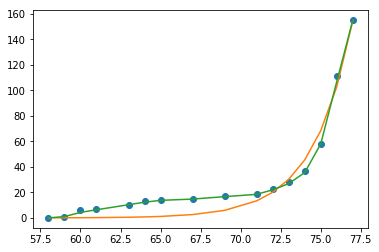

In [39]:
plt.plot(x,y,'o')
plt.plot(x, y_pred)
# plt.plot(x, y_reg)
plt.plot(x, y_pred_cnn)

In [40]:
from sklearn.neural_network import MLPRegressor
x_reg = x_norm.reshape(-1,1)
mlp = MLPRegressor(hidden_layer_sizes=(10,20,10), 
                   tol=1e-4, 
                   max_iter=10000,
                   solver='adam',
                   random_state=0,
                   verbose=1)
mlp.fit(x_reg, y_)

Iteration 1, loss = 1374.81020789
Iteration 2, loss = 1373.95719448
Iteration 3, loss = 1373.09854737
Iteration 4, loss = 1372.23669719
Iteration 5, loss = 1371.37144233
Iteration 6, loss = 1370.49439654
Iteration 7, loss = 1369.61374433
Iteration 8, loss = 1368.72876024
Iteration 9, loss = 1367.83020755
Iteration 10, loss = 1366.92173807
Iteration 11, loss = 1366.00500599
Iteration 12, loss = 1365.06117989
Iteration 13, loss = 1364.11149122
Iteration 14, loss = 1363.12777986
Iteration 15, loss = 1362.11786461
Iteration 16, loss = 1361.06683821
Iteration 17, loss = 1359.97019536
Iteration 18, loss = 1358.86310274
Iteration 19, loss = 1357.74496647
Iteration 20, loss = 1356.61145791
Iteration 21, loss = 1355.46503222
Iteration 22, loss = 1354.30862762
Iteration 23, loss = 1353.14198736
Iteration 24, loss = 1351.96498098
Iteration 25, loss = 1350.77746021
Iteration 26, loss = 1349.58023520
Iteration 27, loss = 1348.37336980
Iteration 28, loss = 1347.14518862
Iteration 29, loss = 1345.900

Iteration 274, loss = 434.20221661
Iteration 275, loss = 432.91153416
Iteration 276, loss = 431.62403422
Iteration 277, loss = 430.38337920
Iteration 278, loss = 429.19055964
Iteration 279, loss = 428.00187077
Iteration 280, loss = 426.82095510
Iteration 281, loss = 425.73875789
Iteration 282, loss = 424.64664334
Iteration 283, loss = 423.54020423
Iteration 284, loss = 422.43941917
Iteration 285, loss = 421.41272027
Iteration 286, loss = 420.38816725
Iteration 287, loss = 419.36799500
Iteration 288, loss = 418.37735068
Iteration 289, loss = 417.39676074
Iteration 290, loss = 416.44506067
Iteration 291, loss = 415.50883224
Iteration 292, loss = 414.57438985
Iteration 293, loss = 413.64319992
Iteration 294, loss = 412.72182747
Iteration 295, loss = 411.82402297
Iteration 296, loss = 410.93856169
Iteration 297, loss = 410.07367688
Iteration 298, loss = 409.21390466
Iteration 299, loss = 408.35526917
Iteration 300, loss = 407.50357635
Iteration 301, loss = 406.67795094
Iteration 302, loss 

Iteration 545, loss = 297.27381571
Iteration 546, loss = 296.97328541
Iteration 547, loss = 296.67208560
Iteration 548, loss = 296.37077510
Iteration 549, loss = 296.06941976
Iteration 550, loss = 295.76807998
Iteration 551, loss = 295.46681072
Iteration 552, loss = 295.16551906
Iteration 553, loss = 294.86320914
Iteration 554, loss = 294.59680340
Iteration 555, loss = 294.26520302
Iteration 556, loss = 293.96929471
Iteration 557, loss = 293.67303533
Iteration 558, loss = 293.37647682
Iteration 559, loss = 293.07967253
Iteration 560, loss = 292.78267650
Iteration 561, loss = 292.48554278
Iteration 562, loss = 292.18832476
Iteration 563, loss = 291.89107451
Iteration 564, loss = 291.59402320
Iteration 565, loss = 291.29744203
Iteration 566, loss = 291.00100674
Iteration 567, loss = 290.70475489
Iteration 568, loss = 290.40872138
Iteration 569, loss = 290.11430579
Iteration 570, loss = 289.81805982
Iteration 571, loss = 289.53295179
Iteration 572, loss = 289.23297777
Iteration 573, loss 

Iteration 802, loss = 217.71636070
Iteration 803, loss = 217.34308394
Iteration 804, loss = 216.96878384
Iteration 805, loss = 216.59570934
Iteration 806, loss = 216.21888240
Iteration 807, loss = 215.84276251
Iteration 808, loss = 215.46401356
Iteration 809, loss = 215.08290017
Iteration 810, loss = 214.70008761
Iteration 811, loss = 214.31581733
Iteration 812, loss = 213.93005653
Iteration 813, loss = 213.54323885
Iteration 814, loss = 213.15610756
Iteration 815, loss = 212.76798220
Iteration 816, loss = 212.37872558
Iteration 817, loss = 211.99004099
Iteration 818, loss = 211.59858698
Iteration 819, loss = 211.20899766
Iteration 820, loss = 210.81832378
Iteration 821, loss = 210.42668215
Iteration 822, loss = 210.03417701
Iteration 823, loss = 209.64090056
Iteration 824, loss = 209.24693409
Iteration 825, loss = 208.85234899
Iteration 826, loss = 208.45720773
Iteration 827, loss = 208.06156481
Iteration 828, loss = 207.66601270
Iteration 829, loss = 207.26980513
Iteration 830, loss 

Iteration 1088, loss = 104.25299045
Iteration 1089, loss = 103.90217362
Iteration 1090, loss = 103.55176529
Iteration 1091, loss = 103.20177754
Iteration 1092, loss = 102.85222177
Iteration 1093, loss = 102.50310877
Iteration 1094, loss = 102.15444875
Iteration 1095, loss = 101.80625143
Iteration 1096, loss = 101.45859112
Iteration 1097, loss = 101.11145691
Iteration 1098, loss = 100.76482280
Iteration 1099, loss = 100.41869651
Iteration 1100, loss = 100.07325249
Iteration 1101, loss = 99.72838058
Iteration 1102, loss = 99.38758047
Iteration 1103, loss = 99.05231259
Iteration 1104, loss = 98.71767655
Iteration 1105, loss = 98.38406717
Iteration 1106, loss = 98.05129285
Iteration 1107, loss = 97.71932214
Iteration 1108, loss = 97.38812361
Iteration 1109, loss = 97.05766452
Iteration 1110, loss = 96.72791051
Iteration 1111, loss = 96.39882579
Iteration 1112, loss = 96.07037385
Iteration 1113, loss = 95.74251852
Iteration 1114, loss = 95.41522507
Iteration 1115, loss = 95.08846130
Iterati

Iteration 1437, loss = 28.01399265
Iteration 1438, loss = 27.89833732
Iteration 1439, loss = 27.78126778
Iteration 1440, loss = 27.66309767
Iteration 1441, loss = 27.54761606
Iteration 1442, loss = 27.43156916
Iteration 1443, loss = 27.31798095
Iteration 1444, loss = 27.20303931
Iteration 1445, loss = 27.08810727
Iteration 1446, loss = 26.97497423
Iteration 1447, loss = 26.86123436
Iteration 1448, loss = 26.74907456
Iteration 1449, loss = 26.63667404
Iteration 1450, loss = 26.52452291
Iteration 1451, loss = 26.41351750
Iteration 1452, loss = 26.30191051
Iteration 1453, loss = 26.19298269
Iteration 1454, loss = 26.08321452
Iteration 1455, loss = 25.97214234
Iteration 1456, loss = 25.86498560
Iteration 1457, loss = 25.75762682
Iteration 1458, loss = 25.64954182
Iteration 1459, loss = 25.54084806
Iteration 1460, loss = 25.43166284
Iteration 1461, loss = 25.32812148
Iteration 1462, loss = 25.22349755
Iteration 1463, loss = 25.11767384
Iteration 1464, loss = 25.01090159
Iteration 1465, loss

Iteration 1770, loss = 7.91864062
Iteration 1771, loss = 7.88545010
Iteration 1772, loss = 7.85233138
Iteration 1773, loss = 7.81928666
Iteration 1774, loss = 7.78635611
Iteration 1775, loss = 7.75352661
Iteration 1776, loss = 7.72077349
Iteration 1777, loss = 7.68813176
Iteration 1778, loss = 7.65557694
Iteration 1779, loss = 7.62310093
Iteration 1780, loss = 7.59072074
Iteration 1781, loss = 7.55844253
Iteration 1782, loss = 7.52624662
Iteration 1783, loss = 7.49415031
Iteration 1784, loss = 7.46215800
Iteration 1785, loss = 7.43024459
Iteration 1786, loss = 7.39843107
Iteration 1787, loss = 7.36671198
Iteration 1788, loss = 7.33507233
Iteration 1789, loss = 7.30354845
Iteration 1790, loss = 7.27210898
Iteration 1791, loss = 7.24074271
Iteration 1792, loss = 7.20949789
Iteration 1793, loss = 7.17834485
Iteration 1794, loss = 7.14727061
Iteration 1795, loss = 7.11627669
Iteration 1796, loss = 7.08539266
Iteration 1797, loss = 7.05461051
Iteration 1798, loss = 7.02390112
Iteration 1799

Iteration 2019, loss = 2.76177466
Iteration 2020, loss = 2.75112174
Iteration 2021, loss = 2.74051557
Iteration 2022, loss = 2.73000036
Iteration 2023, loss = 2.71953338
Iteration 2024, loss = 2.70909621
Iteration 2025, loss = 2.69873288
Iteration 2026, loss = 2.68841575
Iteration 2027, loss = 2.67814490
Iteration 2028, loss = 2.66796008
Iteration 2029, loss = 2.65780397
Iteration 2030, loss = 2.64766692
Iteration 2031, loss = 2.63762757
Iteration 2032, loss = 2.62765009
Iteration 2033, loss = 2.61771561
Iteration 2034, loss = 2.60782404
Iteration 2035, loss = 2.59798567
Iteration 2036, loss = 2.58819032
Iteration 2037, loss = 2.57844789
Iteration 2038, loss = 2.56875006
Iteration 2039, loss = 2.55911626
Iteration 2040, loss = 2.54953865
Iteration 2041, loss = 2.54054381
Iteration 2042, loss = 2.53134476
Iteration 2043, loss = 2.52190076
Iteration 2044, loss = 2.51233784
Iteration 2045, loss = 2.50330405
Iteration 2046, loss = 2.49440224
Iteration 2047, loss = 2.48545930
Iteration 2048

Iteration 2363, loss = 1.19576368
Iteration 2364, loss = 1.19427230
Iteration 2365, loss = 1.19275978
Iteration 2366, loss = 1.19125600
Iteration 2367, loss = 1.18977590
Iteration 2368, loss = 1.18820664
Iteration 2369, loss = 1.18673424
Iteration 2370, loss = 1.18526304
Iteration 2371, loss = 1.18381409
Iteration 2372, loss = 1.18234900
Iteration 2373, loss = 1.18086048
Iteration 2374, loss = 1.17939867
Iteration 2375, loss = 1.17792802
Iteration 2376, loss = 1.17652389
Iteration 2377, loss = 1.17509702
Iteration 2378, loss = 1.17364702
Iteration 2379, loss = 1.17220220
Iteration 2380, loss = 1.17078440
Iteration 2381, loss = 1.16940718
Iteration 2382, loss = 1.16801142
Iteration 2383, loss = 1.16661684
Iteration 2384, loss = 1.16518800
Iteration 2385, loss = 1.16377544
Iteration 2386, loss = 1.16239913
Iteration 2387, loss = 1.16102439
Iteration 2388, loss = 1.15965755
Iteration 2389, loss = 1.15832809
Iteration 2390, loss = 1.15694952
Iteration 2391, loss = 1.15559550
Iteration 2392

Iteration 2609, loss = 0.95056139
Iteration 2610, loss = 0.94988431
Iteration 2611, loss = 0.94926633
Iteration 2612, loss = 0.94865070
Iteration 2613, loss = 0.94793444
Iteration 2614, loss = 0.94732999
Iteration 2615, loss = 0.94671490
Iteration 2616, loss = 0.94608275
Iteration 2617, loss = 0.94543463
Iteration 2618, loss = 0.94477381
Iteration 2619, loss = 0.94410455
Iteration 2620, loss = 0.94346744
Iteration 2621, loss = 0.94280649
Iteration 2622, loss = 0.94217539
Iteration 2623, loss = 0.94152196
Iteration 2624, loss = 0.94089453
Iteration 2625, loss = 0.94025584
Iteration 2626, loss = 0.93960751
Iteration 2627, loss = 0.93901454
Iteration 2628, loss = 0.93840824
Iteration 2629, loss = 0.93771883
Iteration 2630, loss = 0.93710901
Iteration 2631, loss = 0.93648690
Iteration 2632, loss = 0.93586500
Iteration 2633, loss = 0.93523678
Iteration 2634, loss = 0.93459701
Iteration 2635, loss = 0.93397387
Iteration 2636, loss = 0.93335995
Iteration 2637, loss = 0.93274017
Iteration 2638

Iteration 2854, loss = 0.79547206
Iteration 2855, loss = 0.79509061
Iteration 2856, loss = 0.79469042
Iteration 2857, loss = 0.79427249
Iteration 2858, loss = 0.79383898
Iteration 2859, loss = 0.79354273
Iteration 2860, loss = 0.79315758
Iteration 2861, loss = 0.79266282
Iteration 2862, loss = 0.79234189
Iteration 2863, loss = 0.79201156
Iteration 2864, loss = 0.79165748
Iteration 2865, loss = 0.79128166
Iteration 2866, loss = 0.79088518
Iteration 2867, loss = 0.79047144
Iteration 2868, loss = 0.79004259
Iteration 2869, loss = 0.78959932
Iteration 2870, loss = 0.78919057
Iteration 2871, loss = 0.78883731
Iteration 2872, loss = 0.78839573
Iteration 2873, loss = 0.78803177
Iteration 2874, loss = 0.78764994
Iteration 2875, loss = 0.78730219
Iteration 2876, loss = 0.78688658
Iteration 2877, loss = 0.78650207
Iteration 2878, loss = 0.78610791
Iteration 2879, loss = 0.78575304
Iteration 2880, loss = 0.78538360
Iteration 2881, loss = 0.78498985
Iteration 2882, loss = 0.78459586
Iteration 2883

Iteration 3143, loss = 0.70334566
Iteration 3144, loss = 0.70312188
Iteration 3145, loss = 0.70284183
Iteration 3146, loss = 0.70255407
Iteration 3147, loss = 0.70233101
Iteration 3148, loss = 0.70206940
Iteration 3149, loss = 0.70180873
Iteration 3150, loss = 0.70158975
Iteration 3151, loss = 0.70134554
Iteration 3152, loss = 0.70106647
Iteration 3153, loss = 0.70082467
Iteration 3154, loss = 0.70056787
Iteration 3155, loss = 0.70034214
Iteration 3156, loss = 0.70008954
Iteration 3157, loss = 0.69983121
Iteration 3158, loss = 0.69959615
Iteration 3159, loss = 0.69934489
Iteration 3160, loss = 0.69909314
Iteration 3161, loss = 0.69884483
Iteration 3162, loss = 0.69861718
Iteration 3163, loss = 0.69836169
Iteration 3164, loss = 0.69811823
Iteration 3165, loss = 0.69788117
Iteration 3166, loss = 0.69762723
Iteration 3167, loss = 0.69739118
Iteration 3168, loss = 0.69715520
Iteration 3169, loss = 0.69691561
Iteration 3170, loss = 0.69666165
Iteration 3171, loss = 0.69644759
Iteration 3172

Iteration 3519, loss = 0.63400241
Iteration 3520, loss = 0.63387240
Iteration 3521, loss = 0.63375560
Iteration 3522, loss = 0.63363288
Iteration 3523, loss = 0.63350096
Iteration 3524, loss = 0.63337641
Iteration 3525, loss = 0.63325618
Iteration 3526, loss = 0.63313285
Iteration 3527, loss = 0.63299833
Iteration 3528, loss = 0.63287756
Iteration 3529, loss = 0.63274909
Iteration 3530, loss = 0.63262819
Iteration 3531, loss = 0.63250705
Iteration 3532, loss = 0.63238141
Iteration 3533, loss = 0.63226602
Iteration 3534, loss = 0.63214593
Iteration 3535, loss = 0.63201848
Iteration 3536, loss = 0.63190485
Iteration 3537, loss = 0.63178827
Iteration 3538, loss = 0.63166282
Iteration 3539, loss = 0.63153232
Iteration 3540, loss = 0.63141425
Iteration 3541, loss = 0.63129149
Iteration 3542, loss = 0.63117022
Iteration 3543, loss = 0.63105277
Iteration 3544, loss = 0.63093588
Iteration 3545, loss = 0.63082095
Iteration 3546, loss = 0.63070639
Iteration 3547, loss = 0.63058259
Iteration 3548

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [41]:
y_new_pred = mlp.predict(x_reg)
y_new_pred

array([  0.41137997,   2.43040698,   4.449434  ,   6.46846101,
        10.50651505,  12.52554206,  13.49000449,  15.41282045,
        17.31482333,  19.1776025 ,  23.30710783,  27.43661316,
        37.07972453,  59.44562937, 107.99776496, 156.54990055])

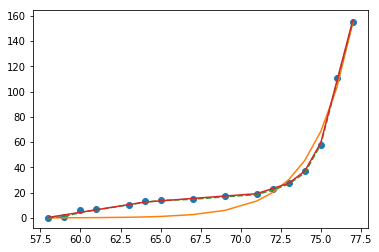

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')
# ax.plot(x, y_reg, '-')
ax.plot(x, y_pred_cnn, '--')
ax.plot(x, y_new_pred, '-')

In [43]:
x_Day = np.array([100])
x_Day = x_Day.reshape(1,-1)
y_day = mlp.predict(x_Day)
y_day

array([20355.35552838])